In [23]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [24]:
from google.colab import files
uploaded = files.upload()


Saving station_data_dataverse.csv to station_data_dataverse (2).csv


In [19]:
# Import pandas
import pandas as pd

# Now you can read the CSV file
df = pd.read_csv('station_data_dataverse.csv')


In [20]:
df.head()

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,0014-11-21 12:05:46,0014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0
3,3173284,6.17,0.00,0014-12-03 19:16:12,0014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,3,0,0,1,0,0,0,0,0
4,3266500,0.93,0.00,0014-12-11 20:56:11,0014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,3,0,0,0,1,0,0,0,0


In [21]:
df.shape

(3395, 24)

In [22]:
df.isna().sum()

sessionId            0
kwhTotal             0
dollars              0
created              0
ended                0
startTime            0
endTime              0
chargeTimeHrs        0
weekday              0
platform             0
distance          1065
userId               0
stationId            0
locationId           0
managerVehicle       0
facilityType         0
Mon                  0
Tues                 0
Wed                  0
Thurs                0
Fri                  0
Sat                  0
Sun                  0
reportedZip          0
dtype: int64

In [23]:
df.dropna(axis=0,inplace=True)


In [24]:
df.shape

(2330, 24)

In [25]:
# Assuming you have loaded your dataset into a pandas DataFrame called 'df'
# Define the dataset columns
columns = ['sessionId', 'kwhTotal', 'dollars', 'platform', 'distance', 'userId', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'reportedZip']

# Assuming your dataset is loaded into a pandas DataFrame called 'df'
# Extracting features (X) and target variable (y)
X = df.drop(columns=['dollars'])  # Features
y = df['dollars']                 # Target variable

# Convert non-numeric columns to one-hot encoded format
X = pd.get_dummies(X)

# Check the shape of X and y after encoding
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Shape of X: (2330, 4668)
Shape of y: (2330,)


In [26]:
accuracies=[]
mses=[]

## Random Forest

In [27]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # Stopping criteria
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return np.mean(y)

        num_features = X.shape[1]
        best_feature, best_threshold, best_gain = None, None, -1

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]

                left_y = y[left_indices]
                right_y = y[right_indices]

                gain = self._information_gain(y, left_y, right_y)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        if best_gain == 0:
            return np.mean(y)

        left_indices = np.where(X[:, best_feature] <= best_threshold)[0]
        right_indices = np.where(X[:, best_feature] > best_threshold)[0]

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_subtree, right_subtree)

    def _information_gain(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        return self._entropy(parent) - (weight_left * self._entropy(left_child) + weight_right * self._entropy(right_child))

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def predict(self, X):
        return np.array([self._predict_row(x, self.tree) for x in X])

    def _predict_row(self, x, tree):
        if isinstance(tree, float):
            return tree

        feature, threshold, left_subtree, right_subtree = tree

        if x[feature] <= threshold:
            return self._predict_row(x, left_subtree)
        else:
            return self._predict_row(x, right_subtree)


In [28]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth)
            # Randomly select subset of features
            if self.max_features:
                subset_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
                X_subset = X[:, subset_indices]
                tree.fit(X_subset, y)
            else:
                tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for tree in self.trees:
            predictions += tree.predict(X)
        return predictions / self.n_estimators


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , r2_score


# Instantiate the RandomForestRegressor model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
random_forest.fit(x_train, y_train)

# Make predictions on the testing data
predictions = random_forest.predict(x_test)
accuracy = r2_score(y_test,predictions)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Accuracy :",accuracy)
print("Mean Squared Error:", mse)

accuracies.append(accuracy)
mses.append(mse)


Accuracy : 0.9685565193127736
Mean Squared Error: 0.00975034633289986


an MSE of approximately 0.042 suggests that the Random Forest regression model is performing well on the given dataset, with predictions that are relatively close to the actual target values.

# **LinearRegression**

In [30]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(x_train, y_train)

# Make predictions on the testing data
predictions = model.predict(x_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print("Accuracy:", r2)
print("Mean Squared Error:", mse)

accuracies.append(r2)
mses.append(mse)

Accuracy: 0.5053830933077459
Mean Squared Error: 0.15337634501501807


# **XGBoost**

In [31]:
import xgboost as xgb

# Create DMatrix for training and testing data (handles categorical features)
dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(x_test, enable_categorical=True)

# Define XGBoost parameters (adjust these as needed)
params = {
    'objective': 'reg:squarederror',  # adjust for classification: 'binary:logistic'
    'max_depth': 5,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the testing data
predictions = model.predict(dtest)

# Evaluate the model (using the same metrics from your previous code)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
accuracies.append(r2)
mses.append(mse)

Mean Squared Error: 0.021634055229596848
R-squared: 0.9302332476639419


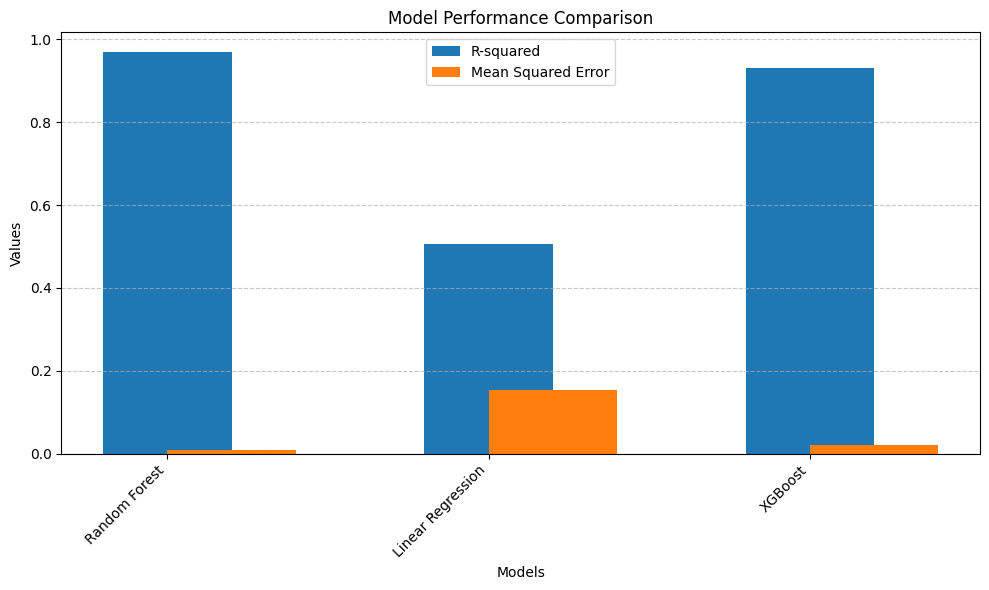

In [32]:
import matplotlib.pyplot as plt

# Model names (assuming you have a list of model names)
model_names = ["Random Forest","Linear Regression","XGBoost"]  # Replace with your actual model names

# Create a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(model_names, accuracies, label='R-squared', width=0.4, align='center')
plt.bar(model_names, mses, label='Mean Squared Error', width=0.4, align='edge')
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the graph
plt.show()
